<a href="https://colab.research.google.com/github/asia281/VisualRecognition2024/blob/main/Asia_of_VR_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

In [2]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 16.1 MB/s eta 0:00:00


In [3]:
import pytorch_lightning as pl

from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
epochs = 5
batch_size = 64
lr = 0.001
device = "gpu"

In [5]:
def add_noise(tensor, idx):
    g = torch.Generator()
    salt = 275991
    g.manual_seed(salt + idx)
    tensor = tensor + torch.normal(mean=0.5, std=0.5, size=tensor.size(), generator=g)
    tensor = torch.clip(tensor, 0, 1)
    return tensor


class MnistForAuto(torch.utils.data.Dataset):
  def __init__(self, dataset, noisy):
    self.dataset = dataset
    self.noisy = noisy

  def __getitem__(self, idx):
    img, _ = self.dataset[idx]

    target = img
    if self.noisy:
      img = add_noise(target, idx)

    return img, target

  def __len__(self):
    return len(self.dataset)



def get_mnist_dataloader(train, noisy: bool):
    transforms = [torchvision.transforms.ToTensor(),]
    mnist = MNIST('files/', train=train, download=True,
                  transform=torchvision.transforms.Compose(transforms))
    mnist_for_auto = MnistForAuto(mnist, noisy)
    return DataLoader(mnist_for_auto, batch_size=batch_size, shuffle=train, num_workers=4)


dataloader_tr = get_mnist_dataloader(train=True, noisy=False)
dataloader_test = get_mnist_dataloader(train=False, noisy=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 221701654.37it/s]

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12965395.89it/s]


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80155438.59it/s]

Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15692363.07it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


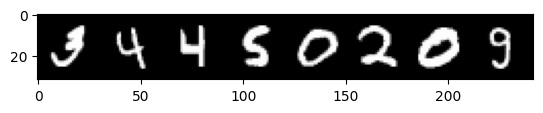

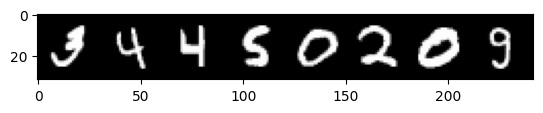

In [6]:
imgs, targets = next(iter(dataloader_tr))

def show(imgs):
  grid = torchvision.utils.make_grid(imgs[:8])
  plt.imshow(grid.numpy().transpose([1, 2, 0]))
  plt.show()

show(imgs)
show(targets)

In [7]:
imgs.shape

torch.Size([64, 1, 28, 28])

#Convolutional autoencoder
Network:
- 3x3 Conv2d, filters=16, stride=2, relu, padding=
- 3x3 Conv2d filters=8, stride=2, relu, padding=
- 3x3 Conv2d filters=8, stride=2, relu, padding=
- 3x3 Conv2d filters=8, relu, padding=
- 2x2 UpsamplingBilinear2d
- 3x3 Conv2d filters=8, relu, padding=
- 2x2 UpsamplingBilinear2d
- 3x3 Conv2d filters=16, relu, padding=
- 2x2 UpsamplingBilinear2d
- 3x3 Conv2d filters=1, sigmoid, padding=

and train it with Adam and binary_crossentropy.

Question: What is the size of the input, output and compressed representations?

In [17]:
class AutoencoderNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x

In [9]:
class EncoderDecoderModel(pl.LightningModule):
    def __init__(self, net):
        super(EncoderDecoderModel, self).__init__()
        self._net = net

    def forward(self, x):
        x = self._net(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self._net.encoder(x)
        x_hat = self._net.decoder(z)
        loss = self.compute_loss(x_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        loss = self.compute_loss(x_hat, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def compute_loss(self, x_hat, x):
        criterion = torch.nn.BCELoss()
        loss = criterion(x_hat, x)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        loss = self.compute_loss(x_hat, y)
        self.log('test_loss', loss)
        num_imgs = 6
        grid_in = torchvision.utils.make_grid(x[:num_imgs])
        grid_out = torchvision.utils.make_grid(x_hat[:num_imgs])
        grid_target = torchvision.utils.make_grid(y[:num_imgs])
        self.logger.experiment.add_image('input', grid_in)
        self.logger.experiment.add_image('output', grid_out)
        self.logger.experiment.add_image('target', grid_target)

In [10]:
def run_experiment(model, dataloader_tr, dataloader_test):
    logger = TensorBoardLogger("runs", name="my_model")
    trainer = pl.Trainer(limit_test_batches=1, limit_val_batches=10, max_epochs=epochs, logger=logger, accelerator=device, devices=1)
    trainer.fit(model=model, train_dataloaders=dataloader_tr, val_dataloaders=dataloader_test)
    trainer.test(model=model, dataloaders=dataloader_test)

In [18]:
model = EncoderDecoderModel(AutoencoderNet1())
from torchsummary import summary

summary(model.cuda(), (1, 28, 28))
run_experiment(model, dataloader_tr, dataloader_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type            | Params
-----------------------------------------
0 | _net | AutoencoderNet1 | 4.4 K 
-----------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3              [-1, 8, 7, 7]           1,160
              ReLU-4              [-1, 8, 7, 7]               0
            Conv2d-5              [-1, 8, 4, 4]             584
              ReLU-6              [-1, 8, 4, 4]               0
            Conv2d-7              [-1, 8, 4, 4]             584
              ReLU-8              [-1, 8, 4, 4]               0
UpsamplingBilinear2d-9              [-1, 8, 8, 8]               0
           Conv2d-10              [-1, 8, 6, 6]             584
             ReLU-11              [-1, 8, 6, 6]               0
UpsamplingBilinear2d-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 16, 14, 14]           1,168
             ReLU-14           [-1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1400471031665802     │
└───────────────────────────┴───────────────────────────┘

# Denoising Autoencoder

Let's generate synthetic noisy digits applying a gaussian noise matrix and clipping images between 0 and 1.

In [12]:
dataloader_tr_noisy = get_mnist_dataloader(train=True, noisy=True)
dataloader_test_noisy = get_mnist_dataloader(train=False, noisy=True)

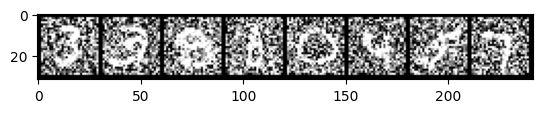

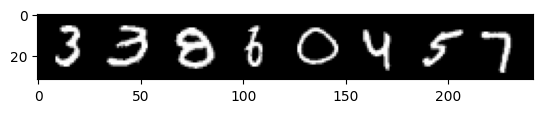

In [13]:
imgs, targets = next(iter(dataloader_tr_noisy))

show(imgs)
show(targets)

Let's define a network:
- 3x3 Conv2d, filters=32, stride=2, relu, padding=
- 3x3 Conv2d, filters=32, stride=2, relu, padding=
- 3x3 Conv2d, filters=32, relu, padding=
- 2x2 UpsamplingBilinear2d
- 3x3 Conv2d, filters=32, relu, padding=
- 2x2 UpsamplingBilinear2d
- 3x3 Conv2d, filters=1, sigmoid, padding=

and train it with Adam and binary_crossentropy.

Question: What is the size of the input, output and compressed representations?

In [14]:
class AutoencoderNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x

In [15]:
model = EncoderDecoderModel(AutoencoderNet2())
run_experiment(model, dataloader_tr_noisy, dataloader_test_noisy)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type            | Params
-----------------------------------------
0 | _net | AutoencoderNet2 | 28.4 K
-----------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.113     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.11646544188261032    │
└───────────────────────────┴───────────────────────────┘

In [16]:
!ls runs

my_model


In [ ]:
# !rm -r runs

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs